In [15]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting

import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size


In [2]:
df = pd.read_csv('../data/clean_train.csv')

In [3]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [4]:
df =  df.drop(['Unnamed: 0', 'pickup_date'], 1)

In [5]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month

# Clustering visualizations

- Make a list of all of the longitudes and latitudes for both pick up and drop off coordinates
- Using MiniBatchKmeans (faster) fit to 15 clusters using the new list of all the geolocation coordinates
- Predict to each of the pickup and dropoff long/lat coords, labeling the clusters, using the model described above

In [6]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)

In [7]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

In [8]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=15, batch_size=10000).fit(loc_df) #fit to 15 clusters using all coordinates
loc_df['label'] = kmeans.labels_

In [9]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])

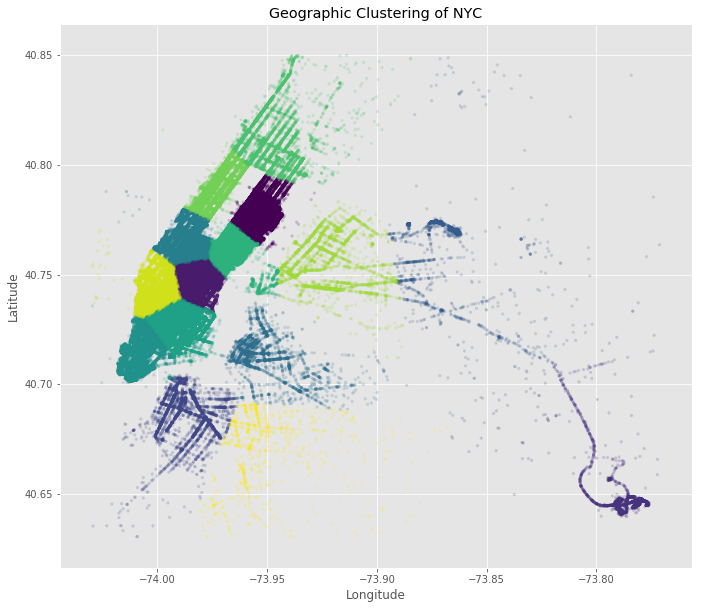

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df.pickup_longitude.values[:500000], df.pickup_latitude.values[:500000], s=10, lw=0,
           c=df.pickup_cluster[:500000].values, alpha=0.2)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Geographic Clustering of NYC')
plt.show()

**Plot of NYC taxi data Clustered by Geographic Location**

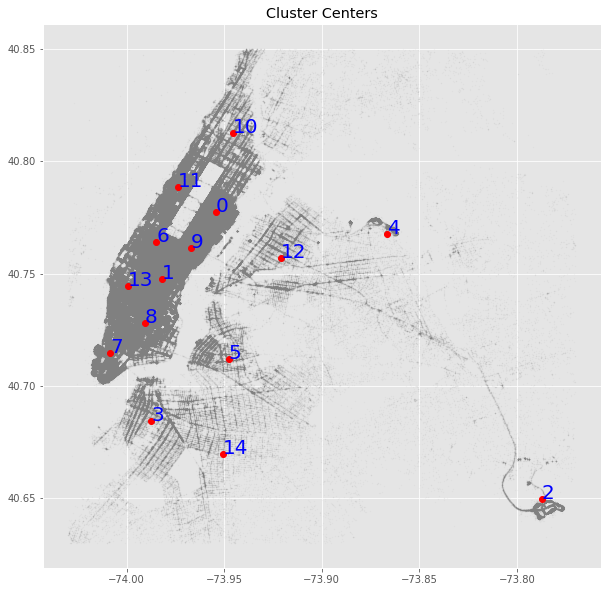

In [11]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

**Cluster Centeres Labeled**

In [36]:
table = df.groupby('pickup_cluster')['dropoff_cluster'].value_counts()
table = pd.DataFrame(table)

In [34]:
table2 = table.unstack(level=1)
table2

dropoff_cluster                                               \
dropoff_cluster              0      1     2     3     4     5      6      7    
pickup_cluster                                                                 
0                         50525  14139   944   691  2201   484  14307   3238   
1                         15437  47341  2487  2848  4609  2338  28960  12386   
2                          1493   3199  3210  1789  2112  1703   4177   1582   
3                           194    667   139  5362   265  1179    379   1177   
4                          2360   4943   805  1839  3495  1464   5889   2295   
5                           111    228    81   818   173  4646    149    228   
6                         16945  30109  2480  1773  5023  1391  47349   8610   
7                          2617  10320   946  4051  1740  2023   8143  20041   
8                          7607  29967  1149  5561  1962  7702  11838  18458   
9                         37919  31627  1579  1428  3772  1305  22678   5948   
10                         3426    657   193    72   487    71   1523    229   
11                        15394   4396   659   290  1214   182  18113   1331   
12                          639    652   199   103  1327   345    390    161   
13                         6911  29142  1088  3128  1930  2399  28744  17078   
14                           10     41    52   543    30   374     29     63   

                                                                
dropoff_cluster     8      9      10     11    12     13    14  
pickup_cluster                                                  
0                 5242  32959   8690  15082  1357   4829   239  
1                29665  28887   2973   5256  2620  28160  1202  
2                 2012   2172    948   1240  1007   1667  1846  
3                  979    486     80     98   134    552  1907  
4                 2214   4084   1427   1714  2234   2071  1045  
5                  915    204     80     68   354    207  1085  
6                11107  25016   6959  21484  2912  24954   913  
7                16560   4922    919   1496   613  14880  1453  
8                46281  11536   2793   3204  2125  27935  3185  
9                11621  34184   3442   8706  3260  10708   521  
10                 420    909  10523   3906   142    604    52  
11                1884   8285  10822  28767   403   3891   112  
12                 277   1228    252    137  5713    236    78  
13               29060  11767   3117   5432  1338  41729  1513  
14                  90     20     23      5    29     40  1326

Text(0.5, 1.0, 'Heatmap version - Value Count of Rides')

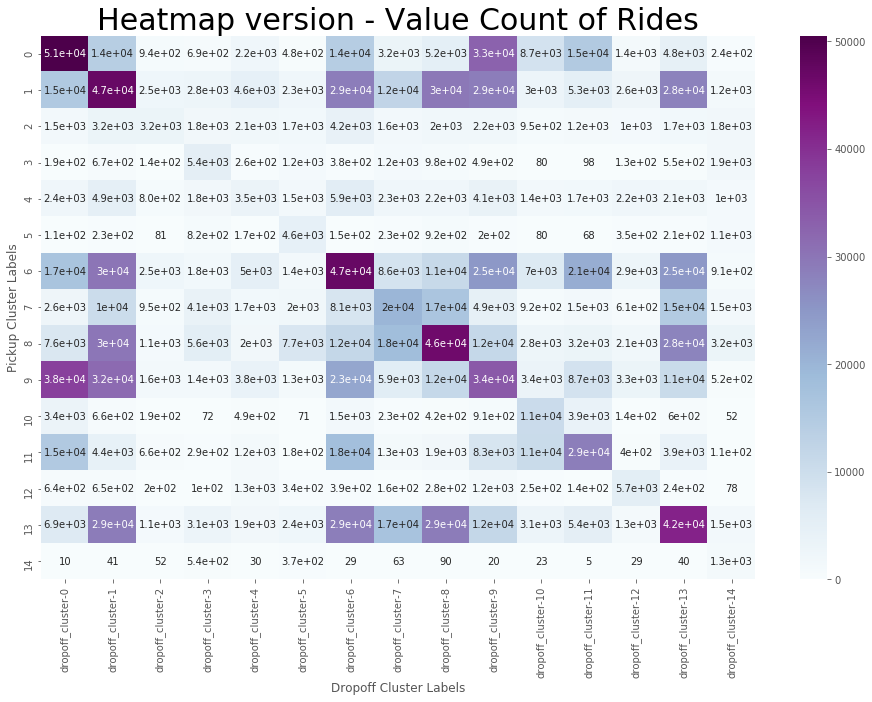

In [59]:
sns.heatmap(table2, annot = True,  cmap="BuPu").set(xlabel= 'Dropoff Cluster Labels', ylabel = 'Pickup Cluster Labels')
plt.title('Heatmap version - Value Count of Rides', fontsize = 30)

The table above can be interpreted as following: the row labels indicate the pickup_cluster labels. the column labels indicate the corresponding dropoff_cluster label. The values are the value counts of the taxi ride intances that the pickup_cluster label resulted in the corresponding dropoff_cluster.

For example, 50525 rides were picked up at cluster 0 and dropped off at cluster 0 (top left corner of the table). Then 15437 rides were picked up at cluster 1 and dropped off at cluster 0 (the cell immediately below the top right corner of the table). The table follows such format etc. 

The heatmap version of the table is a more visually attractive way of seeing which clusters are frequently traversed between via taxis in NYC. Obviously, there is alot of taxi traffic between solely within cluster 0, amounting to more than 50000 rides. The more "purple" the cell, the more rides there are between the two clusters. 

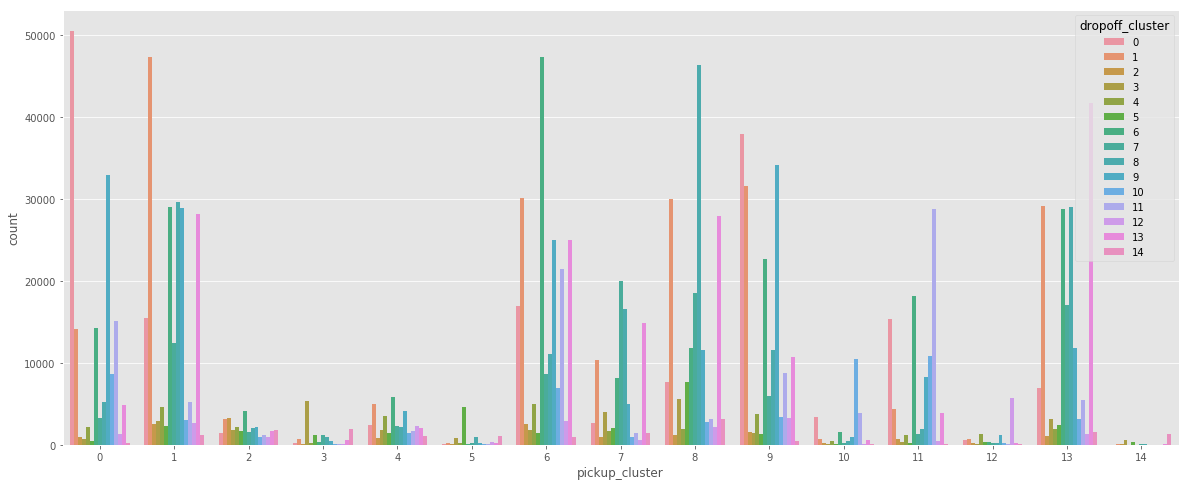

In [13]:
plt.figure(figsize=(20,8))
sns.countplot(x='pickup_cluster', hue='dropoff_cluster', data=df)

As a different way of visualizing the heatmap, the above countplot shows the same visual information as the table aforementioned table. Alot of the times, we start seeing rides that pick up and drop off within the same cluster, suggesting that taxi rides are usually short rides (which we know from seeing the histogram of average taxi ride distances). 

In general, not many people seem to be getting picked up by taxis in clusters 2, 3, 4, 5, 10, 12, and 14. These clusters all correspond to the geographic locations outside of the island of Manhattan. It information also matches up with the density of the scatter plots shown on the cluster labeled plots, as there are significantly less densities of scatter points outside of Manhattan.

[Text(0, 0.5, 'average manhattan distance traveled per ride (km)'),
 Text(0.5, 0, 'pickup_cluster')]

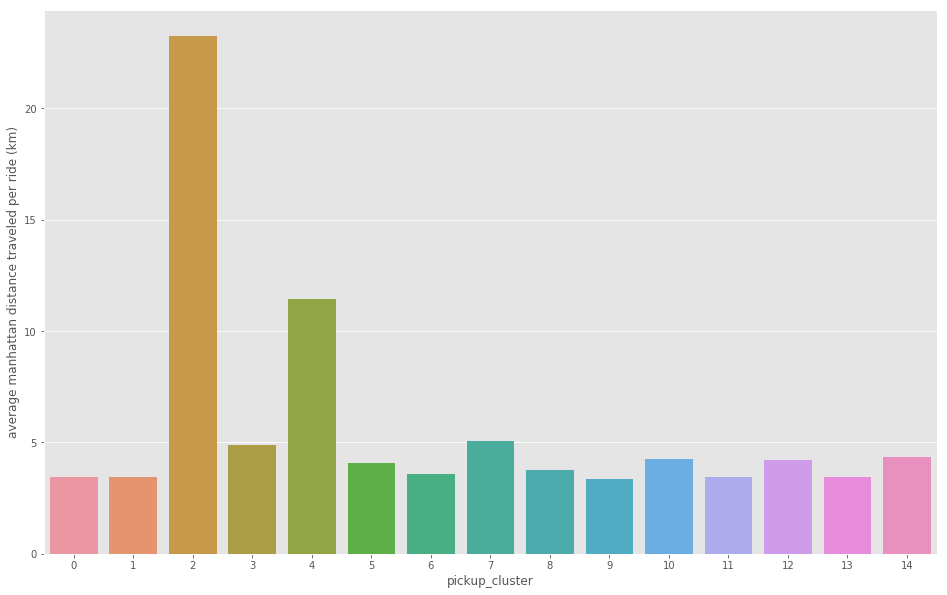

In [52]:
clust_dist = df.groupby('pickup_cluster')['distance_dummy_manhattan'].mean()
sns.barplot(clust_dist.index, clust_dist.values).set(xlabel = 'pickup_cluster', ylabel = 'average manhattan distance traveled per ride (km)')

Accordingly, we can see that clusters 2 and 4 (signifying JFK and La Guardia airports, respectively) have the highest average distance traveled per ride. This is not a surprise, as these are the destinations farthest away from Manhattan proper.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436572 entries, 0 to 1436571
Data columns (total 25 columns):
id                          1436572 non-null object
vendor_id                   1436572 non-null int64
pickup_datetime             1436572 non-null datetime64[ns]
dropoff_datetime            1436572 non-null datetime64[ns]
passenger_count             1436572 non-null int64
pickup_longitude            1436572 non-null float64
pickup_latitude             1436572 non-null float64
dropoff_longitude           1436572 non-null float64
dropoff_latitude            1436572 non-null float64
store_and_fwd_flag          1436572 non-null int64
trip_duration               1436572 non-null int64
date                        1436572 non-null datetime64[ns]
minimum temperature         1436572 non-null int64
precipitation               1436572 non-null float64
snow fall                   1436572 non-null float64
snow depth                  1436572 non-null float64
log_trip_duration           1